In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import warnings
import os

warnings.filterwarnings('ignore')
%matplotlib inline

**Februari 2019**

Jag fick idén att vi borde jämföra utsläpp av växthusgaser inom EU med hur det ser ut i svenska regioner/kommuner. Data på EU-nivå finns hos Eurostat, men frågan är ifall det är kompatibelt med det som finns på kommunal nivå (som finns i Kolada). Här är lite researchanteckningar:

----

Viktiga länkar:

1. Totala utsläpp per EU-land: http://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=env_ac_ainah_r2&lang=en

2. Beskrivning av data: https://ec.europa.eu/eurostat/cache/metadata/en/env_ac_ainah_r2_esms.htm

3. Svensk data framtagen av RUS: http://extra.lansstyrelsen.se/rus/Sv/statistik-och-data/nationell-emissionsdatabas/Pages/default.aspx

Kollade upp kontakterna till RUS (som står som källa till de regionala uppgifterna om utsläpp av växthusgaser i Kolada). Samordnare på RUS hänvisade till Birgit Nielsen som är expert på området. 

Mejlade Birgit och hon svarade att den jämförelse jag är intresserad av får man stämma av med Naturvårdsverket. 

Efter att ha blivit lite runtbollad så hittade jag rätt person på Naturvårdsverket. Han visade sig var superhygglig och veta exakt vad jag önskade. Han rekommenderade mig att istället använda mig av EEA:s siffror då dessa är rakt av de som han är med att ta fram för regionala uträkningar i Sverige. Länk: https://www.eea.europa.eu/data-and-maps/data/data-viewers/greenhouse-gases-viewer

---

**Resultatet publicerades i nr 9 2019, och finns att [läsa på webben här!](https://www.dagenssamhalle.se/nyhet/utslappen-minskar-men-inte-i-norrbotten-26556)**


---

Nu gäller alltså att räkna ut EEA:s siffror per invånare och sedan jämföra med svenska kommuner!

In [3]:
länder = {
    'EU28 (Convention)':'EU28',
    'Euro area (18 countries)':'Euro18',
    'Euro area (19 countries)':'Euro19',
    'European Economic Area (EU27 plus IS, LI, NO)':'EEA27',
    'European Economic Area (EU28 plus IS, LI, NO)':'EEA28',
    'European Free Trade Association':'EFTA',
    'European Union - 27 countries (2007-2013)':'EU27-old',
    'European Union - 27 countries (from 2019)':'EU27-new',
    'European Union - 28 countries':'EU28',
    'EU (KP)':'EU(KP)',
    'Albania':'Albanien',
    'Andorra':'Andorra',
    'Armenia':'Armenien',
    'Austria':'Österrike',
    'Azerbaijan':'Azerbajdzjan',
    'Belarus':'Vitryssland',
    'Belgium':'Belgien',
    'Bosnia and Herzegovina':'Bosnien och Herzegovina',
    'Bulgaria':'Bulgarien',
    'Croatia':'Kroatien',
    'Cyprus':'Cypern',
    'Czech Republic':'Tjeckien',
    'Czechia':'Tjeckien',
    'Denmark':'Danmark',
    'Estonia':'Estland',
    'Finland':'Finland',
    'France':'Frankrike',
    'France (metropolitan)':'Frankrike (Europa)',
    'Georgia':'Georgien',
    'Germany':'Tyskland',
    'Germany (until 1990 former territory of the FRG)':'Tyskland',
    'Germany including former GDR':'Tyskland (inkl tidigare GDR)',
    'Greece':'Grekland',
    'Hungary':'Ungern',
    'Iceland':'Island',
    'Ireland':'Irland',
    'Italy':'Italien',
    'Kosovo (under United Nations Security Council Resolution 1244/99)':'Kosovo',
    'Latvia':'Lettland',
    'Liechtenstein':'Liechtenstein',
    'Lithuania':'Litauen',
    'Luxembourg':'Luxembourg',
    'Malta':'Malta',
    'Moldova':'Moldavien',
    'Monaco':'Monaco',
    'Montenegro':'Montenegro',
    'Netherlands':'Nederländerna',
    'North Macedonia':'Norra Makedonien',
    'Norway':'Norge',
    'Poland':'Polen',
    'Portugal':'Portugal',
    'Romania':'Rumänien',
    'San Marino':'San Marino',
    'Serbia':'Serbien',
    'Slovakia':'Slovakien',
    'Slovenia':'Slovenien',
    'Spain':'Spanien',
    'Sweden':'Sverige',
    'Switzerland':'Schweiz',
    'Turkey':'Turkiet',
    'Ukraine':'Ukraina',
    'United Kingdom':'Storbritannien',
    'United Kingdom (Convention)':'Storbritannien'
}

**Befolkning EU**

In [4]:
pop = pd.read_csv('data/demo_gind_1_Data.csv')
pop.columns = pop.columns.str.lower()

In [5]:
pop.loc[pop['value']==':','value'] = np.nan
pop['value'] = pd.to_numeric(pop['value'].str.replace('\.',''))
pop =  pop[(pop['indic_de'].str.contains('1 January'))&(pop['indic_de'].str.contains('total'))]

In [6]:
pop['geo'] = pop['geo'].map(länder)
pop = pop.drop('indic_de',axis=1).dropna()

**Utsläpp EU**

In [7]:
ems = pd.read_excel('data/eea_data.xlsx')

In [8]:
ems.columns = ems.columns.str.replace("Total \(without LULUCF, without indirect CO2\) - ","")

In [9]:
ems = ems.melt(id_vars=['land','mått'],var_name='år',value_name='miljoner_ton').drop('mått',axis=1)

In [10]:
ems.land = ems.land.map(länder)

In [11]:
ems.år = pd.to_numeric(ems.år)

In [12]:
ems.head()

,land,år,miljoner_ton
0,EU28,1990,5646.080089
1,EU(KP),1990,5652.249726
2,Österrike,1990,78.690048
3,Belgien,1990,146.654019
4,Bulgarien,1990,103.989210


**Utsläpp per inv EU**

In [13]:
ems_inv = ems.merge(pop.rename(columns={'geo':'land','time':'år'}),on=['land','år'],how='left').dropna().rename(columns={'value':'inv'})

In [14]:
ems_inv['ton'] = ems_inv['miljoner_ton']*1000000

In [15]:
ems_inv['ems_p_inv'] = ems_inv['ton']/ems_inv['inv']

In [16]:
ems_inv = ems_inv.drop('miljoner_ton',axis=1)

In [17]:
ems_inv = ems_inv.reset_index(drop=True)[['land','år','ems_p_inv']]

In [18]:
ems_inv = ems_inv[ems_inv['år']>1999].reset_index(drop=True)

In [19]:
ems_inv = ems_inv.pivot_table(index='land',columns='år').round(1).reset_index()

In [20]:
ems_inv.columns = ems_inv.columns.droplevel()

In [21]:
ems_inv.columns = ['land']+ ems_inv.columns[1:].tolist()

In [22]:
ems_inv.head()

,land,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Belgien,14.6,14.4,14.3,14.3,14.4,13.9,13.6,13.1,13.0,11.7,12.2,11.1,10.8,10.7,10.2,10.5,10.4
1,Bulgarien,7.3,7.7,7.6,8.2,8.2,8.3,8.5,9.0,8.9,7.8,8.2,8.9,8.3,7.6,8.1,8.6,8.3
2,Cypern,12.0,11.8,12.0,12.4,12.5,12.6,12.7,12.9,12.8,12.2,11.5,10.9,10.0,9.1,9.6,9.8,10.3
3,Danmark,13.1,13.4,13.3,14.2,13.0,12.1,13.5,12.6,11.9,11.3,11.4,10.4,9.5,9.8,9.0,8.5,8.8
4,EU28,10.6,10.7,10.6,10.7,10.7,10.6,10.5,10.4,10.1,9.3,9.5,9.2,9.0,8.8,8.5,8.5,8.4


**Utsläpp svenska kommuner**

In [23]:
kommuner = pd.read_excel('data/kommuner.xls')

In [24]:
kommuner = kommuner.pivot_table(index='kommun',columns='år').round(1).reset_index()

In [25]:
kommuner.columns = kommuner.columns.droplevel()

In [26]:
kommuner.columns = ['kommun']+ kommuner.columns[1:].tolist()

In [27]:
kommuner.sort_values(2016,ascending=False).head(10)

,kommun,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
170,Oxelösund,232.7,198.5,212.1,196.3,82.4,198.7,174.4,142.4,133.6,137.9,189.8,130.7
133,Lysekil,90.0,122.4,117.1,126.6,128.4,120.3,125.0,130.2,105.7,120.7,127.8,101.8
130,Luleå,55.0,54.7,56.2,53.8,39.6,52.7,49.9,45.7,47.5,47.9,38.8,50.8
197,Stenungsund,45.2,38.7,40.1,36.5,32.6,47.1,42.8,41.2,42.3,40.0,37.6,41.0
51,Gotland,40.3,41.5,36.3,37.1,34.6,38.4,39.8,41.0,38.4,37.9,41.0,38.7
100,Kiruna,29.3,23.2,23.6,23.7,20.3,33.1,33.8,33.3,31.6,32.0,31.1,32.3
149,Mörbylånga,29.5,28.3,26.6,29.5,27.6,29.1,29.9,28.3,26.5,28.2,27.1,25.9
55,Gällivare,24.1,15.5,18.4,18.4,16.3,26.8,27.7,27.3,25.3,25.0,23.7,23.9
178,Rättvik,22.8,21.6,20.5,22.8,19.6,21.2,20.1,18.9,18.2,16.8,18.3,19.7
280,Ödeshög,15.8,16.0,16.1,15.8,15.5,18.0,18.1,17.3,17.3,17.0,16.6,15.6


In [28]:
ems_inv.sort_values(2016,ascending=False).head(10)

,land,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
16,Luxembourg,22.3,23.1,24.6,25.4,28.0,28.2,27.4,25.7,25.1,23.5,24.2,23.5,22.4,20.9,19.6,18.3,17.4
5,Estland,12.3,12.7,12.4,13.9,14.1,14.1,13.7,16.5,14.9,12.5,15.8,15.9,15.2,16.5,16.0,13.7,14.9
10,Island,14.6,14.0,14.1,13.9,14.2,13.5,15.3,15.9,16.7,15.6,15.4,14.5,14.5,14.4,14.3,14.4,14.0
9,Irland,18.1,18.4,17.6,17.3,16.9,16.9,16.4,15.7,15.1,13.6,13.5,12.5,12.6,12.5,12.4,12.7,13.0
29,Tjeckien,14.5,14.5,14.2,14.6,14.6,14.4,14.5,14.6,14.1,13.1,13.3,13.1,12.7,12.2,12.0,12.1,12.3
18,Nederländerna,13.8,13.7,13.5,13.5,13.5,13.1,12.8,12.7,12.6,12.2,12.9,12.0,11.6,11.6,11.1,11.5,11.5
31,Tyskland,12.7,12.9,12.6,12.5,12.3,12.0,12.1,11.8,11.9,11.1,11.5,11.5,11.5,11.7,11.2,11.2,11.1
6,Finland,13.5,14.6,15.0,16.4,15.7,13.3,15.4,15.0,13.4,12.7,14.1,12.6,11.5,11.6,10.8,10.1,10.7
0,Belgien,14.6,14.4,14.3,14.3,14.4,13.9,13.6,13.1,13.0,11.7,12.2,11.1,10.8,10.7,10.2,10.5,10.4
20,Polen,10.2,10.2,9.9,10.3,10.4,10.4,10.8,10.8,10.6,10.2,10.7,10.7,10.5,10.4,10.0,10.1,10.4


Ovan ser vi att det är 8 kommuner som ligger högre än det land i EU som har högst utsläpp per invånare. Nu att kolla hur många svenska kommuner som ligger över EU-snittet:

In [29]:
ems_inv[ems_inv['land']=='EU28']

,land,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
4,EU28,10.6,10.7,10.6,10.7,10.7,10.6,10.5,10.4,10.1,9.3,9.5,9.2,9.0,8.8,8.5,8.5,8.4


In [30]:
kommuner[kommuner[2016]>8.7].shape

(31, 13)

Det är 31 kommuner som ligger över EU:s genomsnitt!

**Utsläpp svenska regioner**

In [31]:
df = pd.read_excel('data/rus_regionrapport.xls')

In [32]:
df.columns = df.iloc[0,:4].tolist() + df.columns[4:].tolist()

In [33]:
df = df.iloc[1:]

In [34]:
for col in df.columns[4:]:
    df[col] = pd.to_numeric(df[col])

In [35]:
df.columns = df.columns.str.lower()

In [36]:
df = df[(df['huvudsektor']=='alla')&(~df['län'].isin(['alla','Rest']))&(df['kommun']=='alla')]

In [37]:
df = df.drop(['huvudsektor','undersektor','kommun'],axis=1).reset_index(drop=True)

In [38]:
pop = pd.read_csv('data/folkmängd_län.csv',encoding="ISO-8859-1")

In [39]:
år = df.columns[1:].tolist()

In [40]:
pop = pop[pop['år'].isin(år)]

In [41]:
pop.head()

,år,region,Folkmängd
0,1990,01 Stockholms län,1641669
1,1990,03 Uppsala län,268835
2,1990,04 Södermanlands län,255636
3,1990,05 Östergötlands län,403011
4,1990,06 Jönköpings län,325163


In [42]:
pop.region = pop.region.str.replace('(\d+ )','')

In [43]:
pop = pop.pivot_table(index='region',columns='år').reset_index().rename(columns={'region':'län'})
pop.columns = pop.columns.droplevel()
pop.columns = ['län']+ pop.columns[1:].tolist()
pop = pop.set_index('län').astype('int')

In [44]:
df = df.sort_values('län').reset_index(drop=True).set_index('län').astype('int')

In [45]:
df = pd.DataFrame((df.values / pop.values), index=df.index, columns=df.columns)

In [46]:
df.sort_values('2016',ascending=True)['2016']

län
Stockholms län           2.153484
Blekinge län             3.747742
Skåne län                4.363264
Uppsala län              4.414602
Värmlands län            4.500014
Örebro län               4.646916
Hallands län             4.682549
Jönköpings län           4.721678
Kronobergs län           4.750185
Gävleborgs län           5.057227
Västmanlands län         5.183904
Östergötlands län        5.216945
Västerbottens län        5.552097
Jämtlands län            5.584023
Västernorrlands län      5.971369
Västra Götalands län     6.076578
Dalarnas län             6.158651
Kalmar län               6.910215
Södermanlands län        9.251297
Norrbottens län         23.193140
Gotlands län            38.742531
Name: 2016, dtype: float64

In [47]:
test = pd.concat([ems_inv.set_index('land')[2016],df.sort_values('2016',ascending=True)['2016']]).round(1)

In [63]:
if not os.path.isdir('res'):
    os.makedirs('res')

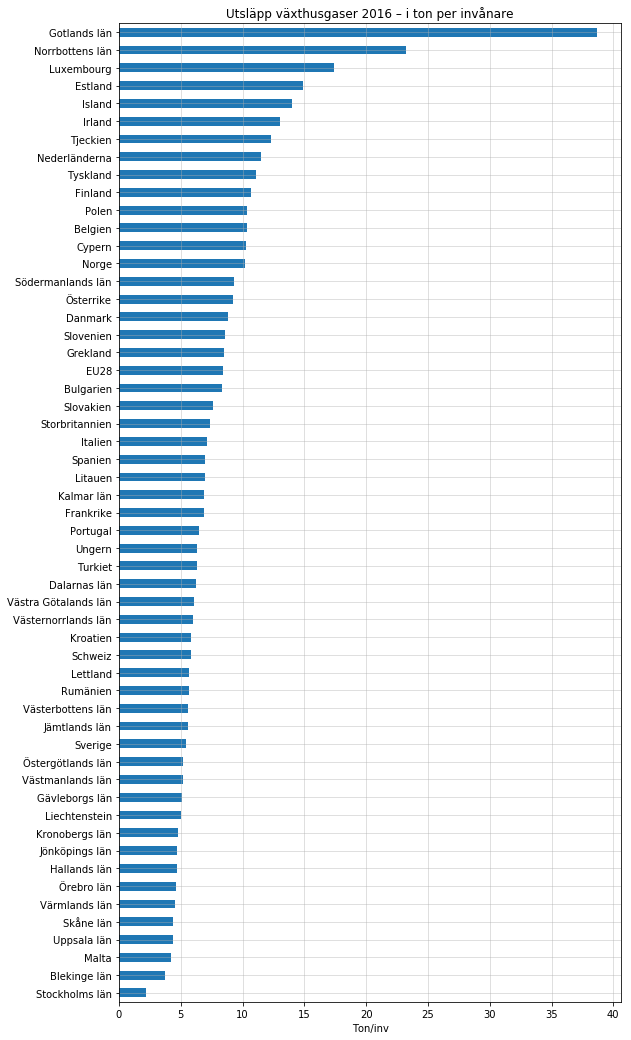

In [50]:
fig, ax = plt.subplots()
test.sort_values(ascending=True).plot(ax=ax,kind='barh',figsize=(9,18))
plt.title('Utsläpp växthusgaser 2016 – i ton per invånare')
plt.xlabel('Ton/inv')
plt.grid(True,alpha=0.5)
plt.savefig('res/graf.png',dpi=100,bbox_inches='tight')

In [51]:
df['diff'] = (((df['2016']/df['2000'])-1)*100).round(1)

In [52]:
ems_inv['diff'] = (((ems_inv[2016]/ems_inv[2000])-1)*100).round(1)

In [53]:
test = pd.concat([ems_inv.set_index('land')['diff'],df.sort_values('diff',ascending=True)['diff']]).round(1)

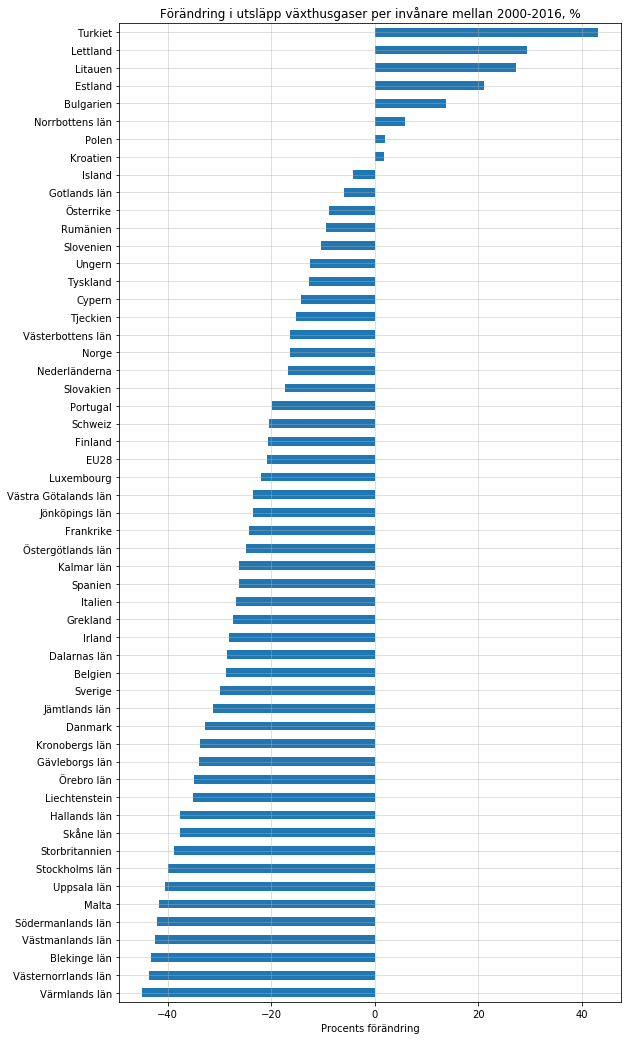

In [54]:
fig, ax = plt.subplots()
test.sort_values(ascending=True).plot(ax=ax,kind='barh',figsize=(9,18))
plt.title('Förändring i utsläpp växthusgaser per invånare mellan 2000-2016, %')
plt.xlabel('Procents förändring')
plt.grid(True,alpha=0.5)
plt.savefig('res/graf_förändring.png',dpi=100,bbox_inches='tight')

In [55]:
w = pd.ExcelWriter('res/resultat.xlsx')

In [56]:
df.to_excel(w,'Svenska regioner')

In [57]:
ems_inv.to_excel(w,'Europa')

In [58]:
w.save()